
----- LINEAR REGRESSION RESULTS -----

Likes Prediction (Linear Regression):
MSE: 197.3606
RMSE: 14.0485
R²: 0.0389

Retweets Prediction (Linear Regression):
MSE: 49.2178
RMSE: 7.0155
R²: 0.0429

----- LOGISTIC REGRESSION RESULTS -----

Likes Category Prediction (Logistic Regression):
Accuracy: 0.4898

Classification Report:
                 precision    recall  f1-score   support

     high_likes       0.56      0.52      0.54        42
      low_likes       0.51      0.62      0.56        32
   medium_likes       0.44      0.49      0.46        35
very_high_likes       0.43      0.34      0.38        38

       accuracy                           0.49       147
      macro avg       0.49      0.49      0.49       147
   weighted avg       0.49      0.49      0.49       147


ROC AUC Scores:
Micro-average AUC: 0.5129

Retweets Category Prediction (Logistic Regression):
Accuracy: 0.5034

Classification Report:
                    precision    recall  f1-score   support

     high_retwe

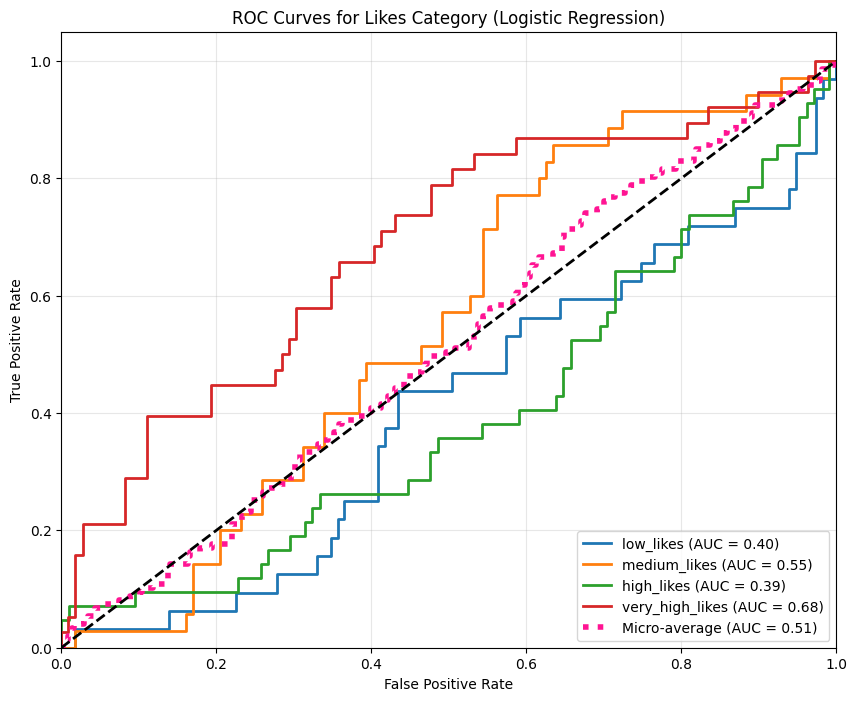

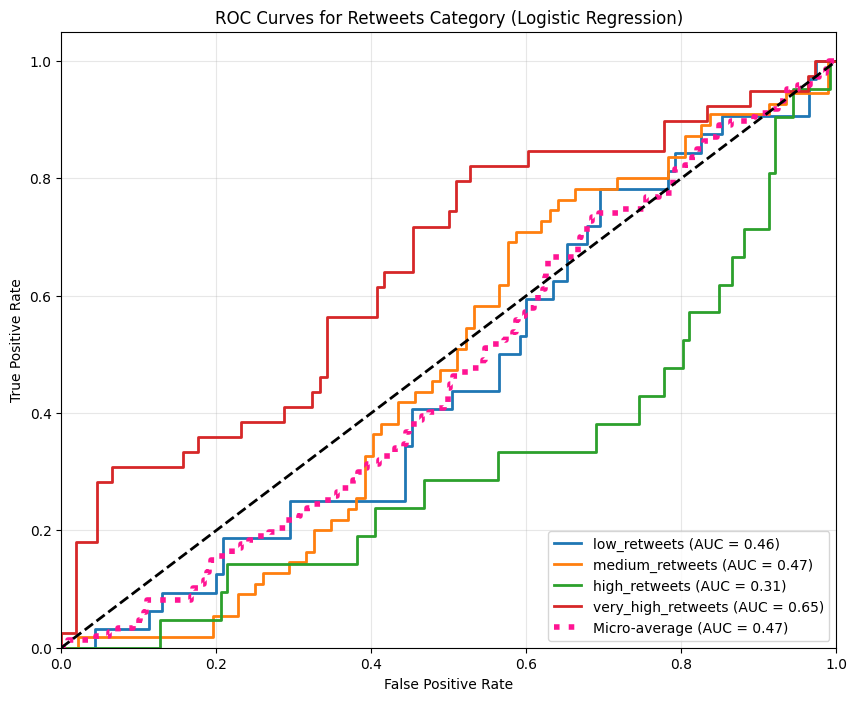

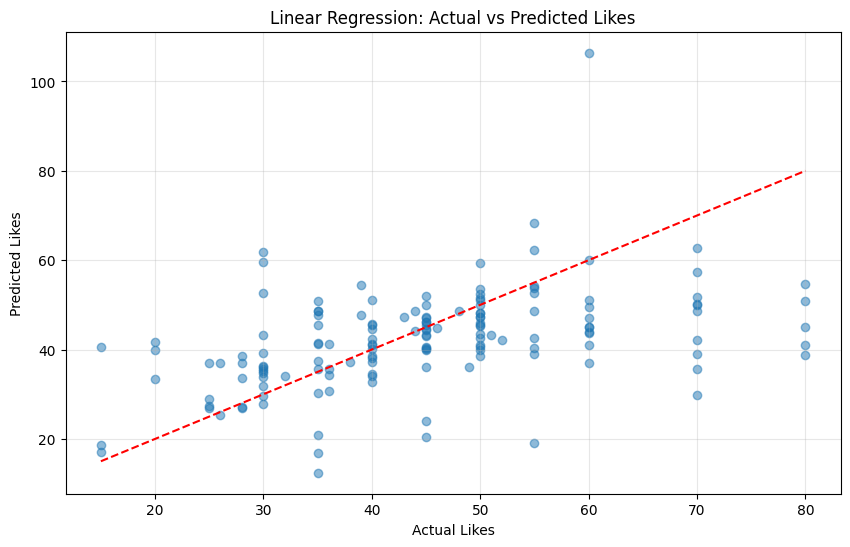

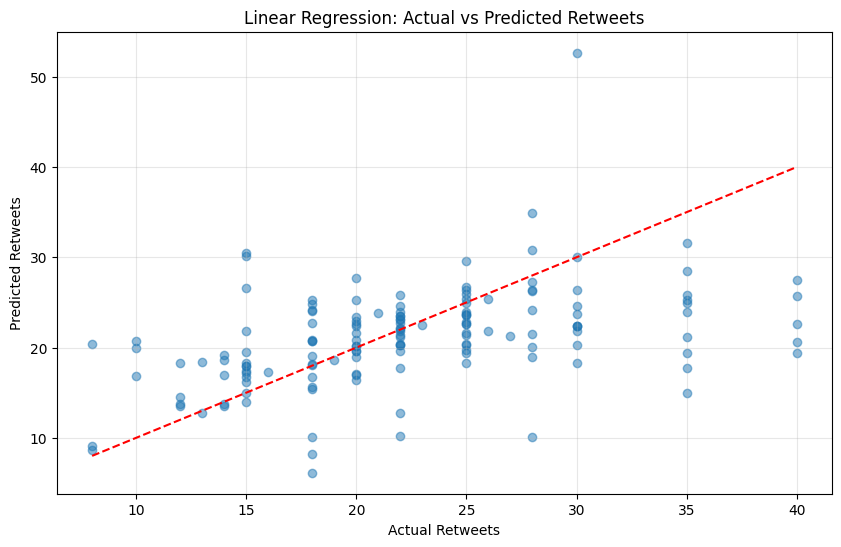

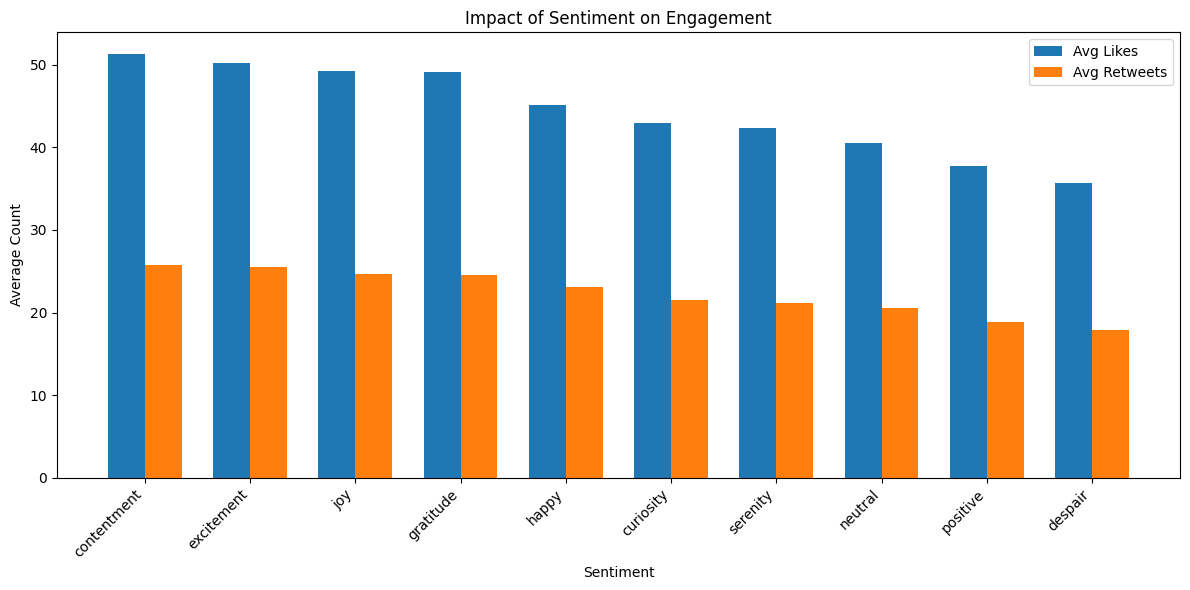

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import re

# Load the dataset
df = pd.read_csv('sentimentdataset.csv')

# ----- PREPROCESSING -----
# Clean string columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

# Clean the Sentiment column
df['Sentiment'] = df['Sentiment'].str.strip().str.lower()

# Create features
df['hashtag_count'] = df['Hashtags'].apply(lambda x: len(str(x).split('#')) - 1)
df['is_weekend'] = df['Day'].apply(lambda x: 1 if x % 7 == 0 or x % 7 == 6 else 0)
df['is_peak_hour'] = df['Hour'].apply(lambda x: 1 if (8 <= x <= 10) or (18 <= x <= 20) else 0)
df['processed_text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

# ----- CREATE TARGET VARIABLES -----
# For Linear Regression: actual likes and retweets values
y_likes = df['Likes']
y_retweets = df['Retweets']

# For Logistic Regression: categorized likes and retweets
df['likes_category'] = pd.qcut(df['Likes'], q=4, labels=['low_likes', 'medium_likes', 'high_likes', 'very_high_likes'])
df['retweets_category'] = pd.qcut(df['Retweets'], q=4, labels=['low_retweets', 'medium_retweets', 'high_retweets', 'very_high_retweets'])
y_likes_cat = df['likes_category']
y_retweets_cat = df['retweets_category']

# ----- DEFINE FEATURES -----
categorical_features = ['Sentiment', 'Platform', 'Country']
numerical_features = ['Year', 'Month', 'Day', 'Hour', 'hashtag_count', 'is_weekend', 'is_peak_hour']
text_feature = 'processed_text'

# Feature dataframe
X = df[numerical_features + categorical_features + [text_feature]]

# ----- DATA SPLITTING -----
# For regression (Linear Regression)
X_train_reg, X_test_reg, y_likes_train_reg, y_likes_test_reg = train_test_split(X, y_likes, test_size=0.2, random_state=42)
_, _, y_retweets_train_reg, y_retweets_test_reg = train_test_split(X, y_retweets, test_size=0.2, random_state=42)

# For classification (Logistic Regression)
X_train_cls, X_test_cls, y_likes_train_cls, y_likes_test_cls = train_test_split(X, y_likes_cat, test_size=0.2, random_state=42)
_, _, y_retweets_train_cls, y_retweets_test_cls = train_test_split(X, y_retweets_cat, test_size=0.2, random_state=42)

# ----- FEATURE PREPROCESSING -----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', CountVectorizer(max_features=50), text_feature)
    ])

# ----- MODEL BUILDING -----
# LINEAR REGRESSION MODELS
# For predicting exact likes
likes_linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# For predicting exact retweets
retweets_linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# LOGISTIC REGRESSION MODELS
# For predicting likes category
likes_logistic_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# For predicting retweets category
retweets_logistic_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# ----- MODEL TRAINING -----
# Train Linear Regression models
likes_linear_model.fit(X_train_reg, y_likes_train_reg)
retweets_linear_model.fit(X_train_reg, y_retweets_train_reg)

# Train Logistic Regression models
likes_logistic_model.fit(X_train_cls, y_likes_train_cls)
retweets_logistic_model.fit(X_train_cls, y_retweets_train_cls)

# ----- MODEL EVALUATION -----
# Evaluate Linear Regression models
likes_pred_reg = likes_linear_model.predict(X_test_reg)
retweets_pred_reg = retweets_linear_model.predict(X_test_reg)

likes_mse = mean_squared_error(y_likes_test_reg, likes_pred_reg)
likes_rmse = np.sqrt(likes_mse)
likes_r2 = r2_score(y_likes_test_reg, likes_pred_reg)

retweets_mse = mean_squared_error(y_retweets_test_reg, retweets_pred_reg)
retweets_rmse = np.sqrt(retweets_mse)
retweets_r2 = r2_score(y_retweets_test_reg, retweets_pred_reg)

# Evaluate Logistic Regression models
likes_pred_cls = likes_logistic_model.predict(X_test_cls)
retweets_pred_cls = retweets_logistic_model.predict(X_test_cls)

likes_proba = likes_logistic_model.predict_proba(X_test_cls)
retweets_proba = retweets_logistic_model.predict_proba(X_test_cls)

likes_accuracy = accuracy_score(y_likes_test_cls, likes_pred_cls)
likes_report = classification_report(y_likes_test_cls, likes_pred_cls)

retweets_accuracy = accuracy_score(y_retweets_test_cls, retweets_pred_cls)
retweets_report = classification_report(y_retweets_test_cls, retweets_pred_cls)

# ----- ROC CURVE ANALYSIS FOR LOGISTIC REGRESSION -----
def plot_roc_curves(y_test, y_proba, class_labels, title, filename):
    # Convert categorical labels to binarized form
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=class_labels)
    
    # Calculate ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(class_labels):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    # Calculate micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], 
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(filename)
    
    return roc_auc

# Plot ROC curves
likes_class_labels = ['low_likes', 'medium_likes', 'high_likes', 'very_high_likes']
likes_roc_auc = plot_roc_curves(
    y_likes_test_cls, 
    likes_proba, 
    likes_class_labels, 
    'ROC Curves for Likes Category (Logistic Regression)', 
    'likes_category_roc.png'
)

retweets_class_labels = ['low_retweets', 'medium_retweets', 'high_retweets', 'very_high_retweets']
retweets_roc_auc = plot_roc_curves(
    y_retweets_test_cls, 
    retweets_proba, 
    retweets_class_labels, 
    'ROC Curves for Retweets Category (Logistic Regression)', 
    'retweets_category_roc.png'
)

# ----- VISUALIZE LINEAR REGRESSION RESULTS -----
# Likes prediction
plt.figure(figsize=(10, 6))
plt.scatter(y_likes_test_reg, likes_pred_reg, alpha=0.5)
plt.plot([y_likes_test_reg.min(), y_likes_test_reg.max()], 
         [y_likes_test_reg.min(), y_likes_test_reg.max()], 'r--')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Linear Regression: Actual vs Predicted Likes')
plt.grid(True, alpha=0.3)
plt.savefig('likes_linear_regression.png')

# Retweets prediction
plt.figure(figsize=(10, 6))
plt.scatter(y_retweets_test_reg, retweets_pred_reg, alpha=0.5)
plt.plot([y_retweets_test_reg.min(), y_retweets_test_reg.max()], 
         [y_retweets_test_reg.min(), y_retweets_test_reg.max()], 'r--')
plt.xlabel('Actual Retweets')
plt.ylabel('Predicted Retweets')
plt.title('Linear Regression: Actual vs Predicted Retweets')
plt.grid(True, alpha=0.3)
plt.savefig('retweets_linear_regression.png')

# ----- SENTIMENT ANALYSIS -----
# Analyze sentiment influence on engagement
def analyze_sentiment_impact():
    # Get top sentiments by count
    top_sentiments = df['Sentiment'].value_counts().head(10).index.tolist()
    
    # Filter data for top sentiments
    sentiment_data = df[df['Sentiment'].isin(top_sentiments)]
    
    # Create a pivot table for average likes and retweets by sentiment
    sentiment_pivot = sentiment_data.groupby('Sentiment').agg({
        'Likes': 'mean',
        'Retweets': 'mean'
    }).reset_index()
    
    # Sort by likes
    sentiment_pivot_likes = sentiment_pivot.sort_values('Likes', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(sentiment_pivot_likes))
    width = 0.35
    
    plt.bar(x - width/2, sentiment_pivot_likes['Likes'], width, label='Avg Likes')
    plt.bar(x + width/2, sentiment_pivot_likes['Retweets'], width, label='Avg Retweets')
    
    plt.xlabel('Sentiment')
    plt.ylabel('Average Count')
    plt.title('Impact of Sentiment on Engagement')
    plt.xticks(x, sentiment_pivot_likes['Sentiment'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sentiment_impact.png')
    
    return sentiment_pivot_likes

sentiment_impact = analyze_sentiment_impact()

# ----- PRINT RESULTS -----
print("\n----- LINEAR REGRESSION RESULTS -----")
print("\nLikes Prediction (Linear Regression):")
print(f"MSE: {likes_mse:.4f}")
print(f"RMSE: {likes_rmse:.4f}")
print(f"R²: {likes_r2:.4f}")

print("\nRetweets Prediction (Linear Regression):")
print(f"MSE: {retweets_mse:.4f}")
print(f"RMSE: {retweets_rmse:.4f}")
print(f"R²: {retweets_r2:.4f}")

print("\n----- LOGISTIC REGRESSION RESULTS -----")
print("\nLikes Category Prediction (Logistic Regression):")
print(f"Accuracy: {likes_accuracy:.4f}")
print("\nClassification Report:")
print(likes_report)
print("\nROC AUC Scores:")
print(f"Micro-average AUC: {likes_roc_auc['micro']:.4f}")

print("\nRetweets Category Prediction (Logistic Regression):")
print(f"Accuracy: {retweets_accuracy:.4f}")
print("\nClassification Report:")
print(retweets_report)
print("\nROC AUC Scores:")
print(f"Micro-average AUC: {retweets_roc_auc['micro']:.4f}")

print("\n----- SENTIMENT IMPACT ON ENGAGEMENT -----")
print("\nTop Sentiments by Average Engagement:")
print(sentiment_impact.head(10))

# ----- PREDICTION FUNCTION -----
def predict_engagement(text, sentiment, platform, country, year, month, day, hour, hashtags):
    # Process input
    hashtag_count = len(hashtags.split('#')) - 1 if hashtags else 0
    is_weekend = 1 if day % 7 == 0 or day % 7 == 6 else 0
    is_peak_hour = 1 if (8 <= hour <= 10) or (18 <= hour <= 20) else 0
    processed_text = re.sub(r'[^\w\s]', '', text).strip()
    
    # Create a dataframe for the new post
    new_post = pd.DataFrame({
        'Year': [year],
        'Month': [month],
        'Day': [day],
        'Hour': [hour],
        'hashtag_count': [hashtag_count],
        'is_weekend': [is_weekend],
        'is_peak_hour': [is_peak_hour],
        'Sentiment': [sentiment.lower().strip()],
        'Platform': [platform.strip()],
        'Country': [country.strip()],
        'processed_text': [processed_text]
    })
    
    # Make predictions
    # Linear Regression predictions (exact values)
    predicted_likes = round(likes_linear_model.predict(new_post)[0])
    predicted_retweets = round(retweets_linear_model.predict(new_post)[0])
    
    # Logistic Regression predictions (categories)
    predicted_likes_category = likes_logistic_model.predict(new_post)[0]
    predicted_retweets_category = retweets_logistic_model.predict(new_post)[0]
    
    # Get probabilities for categories
    likes_category_probs = dict(zip(likes_class_labels, 
                                    likes_logistic_model.predict_proba(new_post)[0]))
    retweets_category_probs = dict(zip(retweets_class_labels, 
                                       retweets_logistic_model.predict_proba(new_post)[0]))
    
    return {
        # Linear Regression results
        'predicted_likes': predicted_likes,
        'predicted_retweets': predicted_retweets,
        
        # Logistic Regression results
        'predicted_likes_category': predicted_likes_category,
        'likes_category_probabilities': likes_category_probs,
        'predicted_retweets_category': predicted_retweets_category,
        'retweets_category_probabilities': retweets_category_probs
    }

# Example usage
if __name__ == "__main__":
    # Test prediction with a sample post
    sample_post = {
        'text': "Having an amazing day at the beach! Perfect sunset! #beach #sunset #happy",
        'sentiment': "positive",
        'platform': "Instagram",
        'country': "USA",
        'year': 2023,
        'month': 7,
        'day': 15,
        'hour': 19,
        'hashtags': "#beach #sunset #happy"
    }
    
    prediction = predict_engagement(**sample_post)
    
    print("\n----- SAMPLE PREDICTION -----")
    print(f"Post: {sample_post['text']}")
    print(f"Sentiment: {sample_post['sentiment']}")
    print(f"Platform: {sample_post['platform']}")
    
    print("\nLinear Regression Predictions:")
    print(f"Predicted Likes: {prediction['predicted_likes']}")
    print(f"Predicted Retweets: {prediction['predicted_retweets']}")
    
    print("\nLogistic Regression Predictions:")
    print(f"Predicted Likes Category: {prediction['predicted_likes_category']}")
    print(f"Predicted Retweets Category: {prediction['predicted_retweets_category']}")
    
    print("\nCategory Probabilities:")
    print("Likes Categories:")
    for category, prob in prediction['likes_category_probabilities'].items():
        print(f"  {category}: {prob:.4f}")
    
    print("\nRetweets Categories:")
    for category, prob in prediction['retweets_category_probabilities'].items():
        print(f"  {category}: {prob:.4f}")

In [ ]:
# Echo
from scipy.stats import ttest_ind

# 先标准化情绪列（去除空格、小写）
df['Sentiment_clean'] = df['Sentiment'].str.strip().str.lower()

# 定义情绪分组（按你的数据里的真实标签来分）
positive_emotions = [
    'positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration',
    'affection', 'awe', 'surprise', 'adoration', 'anticipation', 'calmness',
    'gratitude', 'hope', 'contentment', 'serenity', 'empowerment', 'compassion',
    'tenderness', 'elation', 'euphoria', 'enthusiasm', 'pride', 'kind',
    'zest', 'grateful', 'hopeful', 'inspired', 'confident', 'empathetic',
    'playful', 'free-spirited', 'proud', 'reverence', 'fulfillment'
]

negative_emotions = [
    'negative', 'anger', 'fear', 'sadness', 'disgust', 'shame', 'disappointed',
    'bitter', 'confusion', 'despair', 'grief', 'loneliness', 'jealousy',
    'resentment', 'frustration', 'boredom', 'anxiety', 'intimidation',
    'helplessness', 'envy', 'regret', 'numbness', 'melancholy',
    'fearful', 'apprehensive', 'bitterness'
]

# 提取对应分组的 Likes 列
positive_likes = df[df['Sentiment_clean'].isin(positive_emotions)]['Likes']
negative_likes = df[df['Sentiment_clean'].isin(negative_emotions)]['Likes']

# 执行独立样本 t 检验
t_stat, p_value = ttest_ind(positive_likes, negative_likes, equal_var=False)

# 输出统计结果
print(f"Positive Emotion Posts: Mean Likes = {positive_likes.mean():.2f}, Std = {positive_likes.std():.2f}, N = {positive_likes.count()}")
print(f"Negative Emotion Posts: Mean Likes = {negative_likes.mean():.2f}, Std = {negative_likes.std():.2f}, N = {negative_likes.count()}")
print(f"t-statistic = {t_stat:.2f}")
print(f"p-value = {p_value:.4e}")

# 输出结论
if p_value < 0.05:
    print("Result: Reject the null hypothesis. Positive emotion posts receive significantly more likes.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference.")


Positive Emotion Posts: Mean Likes = 43.73, Std = 12.36, N = 280
Negative Emotion Posts: Mean Likes = 31.00, Std = 13.57, N = 112
t-statistic = 8.60
p-value = 3.0166e-15
Result: Reject the null hypothesis. Positive emotion posts receive significantly more likes.
